# Shor's algorithm

Shor's algorithmn is famously known to be able to factor a number in polynomial time, whereas the best know classical algorithm does it in superpolynomial time. 

The factoring problem can be reduced to the period finding problem, and the quantum part of Shor algorithms solves exactly this problem. So we will see how this algorithm solves period finding problem and later see how this applies to factoring.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


## Order finding

Consider the function:

$$
f(x)=a^x \text{ mod N}
$$

$a \le N$ and $N$ are positive integers which are also relative primes (no common factor). The order $r$ of the function is the smallest non zero integer such that

$$
a^r \text{ mod N}=1
$$

For example, take $a=3, N=35$:

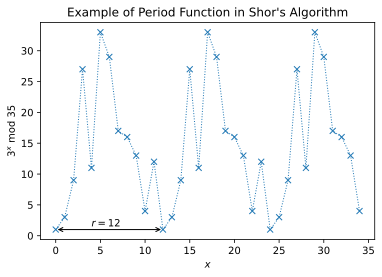

In [2]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

#use matplotlib to plot data in a nice way
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$', title="Example of Period Function in Shor's Algorithm")
try:
    r=yvals[1:].index(1)+1 #we find the index of the next y value equal to 1
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text=f'$r={r}$', xy=(r/3, 1.5))
except:
    print('Could not find the period, check a<N and have no common factors')

### Shor solution

Shor solution was to use QPE algorithm to solve the period finding problem seen above, by estimating the phase of the unitary operator:
$$
U |y\rangle = |a \, y \, \text{ mod N}\rangle 
$$
to see how this relates to period finding, consider applying it to $|1\rangle$ (first state of the computational basis) repeatedly, it will result in multiplying the state of our register by $a$ and then taking the module $N$ each time. After $r$ repetitions we will be back at the state $|1\rangle$, due to the period $r$ of the function $f(x)$ seen before, the register being in the same states as the picture above for $a=3, N=35$.

A superposition of the states in this cycle would be:

$$
|u_0\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} |a^k \text{ mod N}\rangle
$$

which is an **eigenstate** of $U$:

$$
U |u_0\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} |a^{k+1} \text{ mod N}\rangle = |u_0\rangle
$$

where the last equality is because $a^{r} \text{ mod N}=a^0 \text{ mod N}=1$. It has eigenvalue 1. 

So a superposition of the states inside a full period of $U$ is an eigenstate of $U$, though it only has eigenvalue 1. A more interesting eigenstate can be obtained by having a superposition of the states with different phases, for example a state in which the phase of the $k$-th basis state is proportional to $k$:

$$
\begin{aligned}
|u_1\rangle &= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i k}{r}} |a^{k} \text{ mod N}\rangle\\
U|u_1\rangle &= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i k}{r}} |a^{k+1} \text{ mod N}\rangle = e^{\frac{2 \pi i}{r}} |u_1\rangle
\end{aligned}
$$

where the last equality again holds because $e^{\frac{2 \pi i}{r}} e^{-\frac{2 \pi i r}{r}} |a^r \text{ mod N}\rangle = e^{\frac{2 \pi i}{r}} |a^{0} \text{ mod N}\rangle$. Again, we can further generalize this adding a multiplicative constant $s$ to the phase:

$$
\begin{aligned}
|u_s\rangle &= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i s k}{r}} |a^{k} \text{ mod N}\rangle\\
U|u_s\rangle &= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i s k}{r}} |a^{k+1} \text{ mod N}\rangle = e^{\frac{2 \pi i s}{r}} |u_1\rangle
\end{aligned}
$$

and it shows up in the eigenvalue, which now depends on $s$ and $r$. We now have a unique eigenstate for each integer value of $0 \le s \le r-1$. If we use the QPE algorithm, we could estimate the ratio $s/r$ and hence $r$ up to high accuracy. But to prepare $|u_s\rangle$ we need to actually know $r$ beforehand, which defeats the purpose of the algorithm. There's an interesting observation to circumvent this problem, if we sum all these states

$$
\begin{aligned}
\frac{1}{\sqrt{r}} \sum_{s=0}^{r-1} |u_s\rangle &= \frac{1}{r} \sum_{s=0}^{r-1} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i s k}{r}} |a^{k} \text{ mod N}\rangle\\
&= \frac{1}{r} \sum_{k=0}^{r-1} \underbrace{\sum_{s=0}^{r-1} e^{-\frac{2 \pi i s k}{r}}}_{\alpha_{k,r}} |a^k \text{ mod N}\rangle\\
\end{aligned}
$$

and we can easily show that $\alpha_{k,r} = r \delta_{k,0}$. Notice that the summands are all the $r$-th roots of unity raised to $k$-th power, thus shifting the summing index $s$ by 1 will cause us to obtain

$$
\alpha_{k,r} = e^{-\frac{2 \pi i k}{r}} \alpha_{k, r}
$$

which implies the above. Thus

$$
\frac{1}{\sqrt{r}} \sum_{s=0}^{r-1} |u_s\rangle =|1\rangle
$$

So the computational basis state $|1\rangle$ (trivial to prepare) is a superposition of all eigenstates $|u_s\rangle$ of $U$. Notice at this point that

$$
U |1\rangle = \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1} e^{\frac{2 \pi s}{r}} |u_s\rangle
$$

Now we can apply the QPE algorithm, but we first need an observation to understand the result. Recall that the QPE algorithm required a counting register in the state $|0\rangle$ and a second register in the state $|u\rangle$ such that $U|u\rangle=e^{i \theta_u}|u\rangle$, and allowed use to estimate $\theta$ from this setup. Consider the situation where we cannot prepare a single eigenstate of $U$ but another state $|\psi\rangle$, since $U$ is a unitary we can expand it in $|u\rangle$ basis like $|\psi\rangle = \sum_u c_u |u\rangle$. We can then expect, intuitively, the QPE algorithm to behave as follows

$$
|0\rangle |\psi\rangle = \sum_u c_u |0\rangle |u\rangle \implies \sum_u c_u |\tilde{\theta_u}\rangle |u\rangle
$$

where $\tilde{\theta_u}$ is some good approximation to $\theta_u$. We can read the first register to read out $\tilde{\theta_u}$ with probability $|c_u|^2$. 

Apply this argument to $|1\rangle$ above, we see that for each $s$ we will obtain an estimation of $\theta_s \approx s/r$ with probability $(1-\epsilon)/r$, where $\epsilon$ is the required error. Remember the argument about the approximation of QPE (check Neilsen and Chuang), we know that if we take the qubit in the counting register of the QPE algorithm to be $t = 2L+1+\lceil\log(2+1/(2\epsilon))\rceil$ we will obtain the result with the probability given before and an accuracy of $2L+1$ bits, where $L=\lceil\log(N)\rceil$ is the number of bits to represent $N$ in $a^k \text{ mod N}$, and is also the number of quibits used in the second register.

Obtained the estimation of $s/r$, for any $s$, we need the continued fraction algorithm in order to extract $r$.

#### Continued fraction

So now that we have $\theta \approx s/r$, we need to get $r$, and we do this by using the continue fraction expansion algorithm.

The continued fraction expansion is a representation of any real number by using fractions of integers in the following way

$$
[a_0, \dots, a_M] = a_0 + \frac{1}{a_1 + \frac{1}{a_2 + \frac{1}{\dots  + \frac{1}{a_M}}}}
$$

We call $[a_0, \dots, a_m]$ with $0 \le m \le M$ the *m-th convergent*. The continued fraction algorithm is a procedure to compute this representation, it works like this: consider $31/13$, we want to compute its CF representation, we first split it into a integer part and a fractional part $31/13=2 + \frac{5}{13}$, then we invert the fractional part so that it has a 1 in the numerator and repeat the step before

$$
31/13 = 2 + \frac{1}{\frac{13}{5}} = 2 + \frac{1}{2 + \frac{3}{5}}
$$

repeat, and we arrive at the last step

$$
31/13 = 2 + \frac{1}{2 + \frac{3}{5}} = 2 + \frac{1}{2 + \frac{1}{1 + \frac{2}{3}}} = 2 + \frac{1}{2 + \frac{1}{1 + \frac{1}{1+\frac{1}{2}}}}
$$

we stop here because $1/2$ already has 1 at the numerator, so we conclude the algorithm. All rational numbers will have finite representations that can be found using rational fraction algorithm, while other reals will have infinite ones.

How is it helpful? 

Consider $[a_0, \dots, a_N]$ we have that for each $n$-th convergent

$$
[a_0, \dots, a_n] = \frac{p_n}{q_n}
$$

where $p_n, q_n$ are two integer values defined in a recursive way as $p_0=a_0, q_0=1$ and 

$$
p_n = a_n p_{n-1} + p_{n-2}\\
q_n = a_n q_{n-1} + q_{n-2}
$$

this means that each convergent can be expressed as a rational number, but most importantly implies the following

**Theorem** consider $p/q$ and $x$ both rational numbers such that

$$
\Big\lvert \frac{p}{q} - x \Big\rvert \le \frac{1}{2 q^2}
$$

then $p/q$ is a convergent of the continued fraction representation for $x$.

This means that if $p/q=[a_0, \dots, a_n]$, then $x=[a_0, \dots, a_n, b_0, \dots, b_m]$, but most importantly we have that $p/q$ can be computed by applying the continued fraction algorithm to $x$. 

Going back to our problem, remember that $\theta$ is an approximation of $s/r$ accurate to $2L+1$ bits, thus

$$
\Big\lvert \frac{s}{r} - \theta \Big\rvert \le 2^{-2L-1} \le \frac{1}{2 r^2}
$$

which means that the we can apply the argument above. Thus we apply the continued fraction algorithm to $\theta$ and extract the numbers $p_n$ and $q_n$ for each convergent, each $q_n$ will be a candidate for $r$ which we can check by computing $x^r \text{ mod N}$! This can be computed with the complexity $O(L^3)$ of the continued fraction algorithm.

So the algorithm can give a correct answer with $O(L^3)$ complexity. There are some more observation because this might give an incorrect answer: remember that $s$ is chosen uniformly from $[0, r-1]$ and might have a factor in common with $r$, in this case the continued factoring algorithm will return $s',r'$ which are different from $s,r$ (smaller, since they won't have factors in common). The Nielsen Chuang book gives three strategies to circumvent this problem.

## Qiskit implementation

We now solve the problem for an example with $a=7, N=15$ (in this case $r=4$) and

$$
U|y\rangle=|a y \text{ mod N}\rangle
$$

We will provide the circuit to implement $U$ to test this example, and then explain it only later. To have $U^x$ we will simply repeat this circuit $x$ times. The function `c_amod15` return the controlled $U$ gate and allows us to specify $a$ (while $N=15$ is fixed), repeated up to `power` times:

In [3]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13 (i.e. must be co-prime of and below 15)")
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control() #returns the controlled version of a gate
    return c_U

The circuit for inverse QFT is the usual

In [4]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

And we now can put everything together in a simple function

In [5]:
def order_finding(a, n_count):
    #QC with n_count counting qubits and 4 qubits in the state |1> 
    #to apply U
    qc = QuantumCircuit(n_count+4, n_count)

    for q in range(n_count):
        qc.h(q) #intialize to |+..+>
    # we put the second register in |1> state
    # i.e. the first state after the |0...0> state, |0...01>
    qc.x(3+n_count) #only last qubit to 1

    #do the C-U^2^j operations
    for q in range(n_count):
        qc.append(c_amod15(a, 2**q), [q]+[i+n_count for i in range(4)])

    #apply the inverse QFT
    qc.append(qft_dagger(n_count), range(n_count))

    #measure the counting register
    qc.measure(range(n_count), range(n_count))
    return qc

So we use $4$ qubits in the second register since $L=\lceil\log 15\rceil=4$, whereas in the first register we use $n=8$ qubits. Now we build the circuit with $a=7$

In [9]:
a=7
n_count=8
qc = order_finding(a,n_count)
qc.draw('text')

┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐»
 q_8: ─────┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■─────────────────────────»
«             │               │               │                         »
« q_7: ───────┼───────────────┼───────────────┼────────────────■────────»
«      ┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴┼───────┐»
« q_8: ┤0             ├┤0             ├┤0             ├┤0      │       ├»
«      │              ││              ││              ││               │»
« q_9: ┤1             ├┤1             ├┤1             ├┤1              ├»
«      │  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │»
«q_10: ┤2             ├┤2             ├┤2             ├┤2              ├»
«      │              ││              ││              ││               │»
«q_11: ┤3             ├┤3             ├┤3             ├┤3              ├»
«      └──────────────┘└──────────────┘└──────────────┘└───────────────┘»
« c: 8/═════════════════════════════════════════════════════════════════»
«                                                                       »
«      ┌───────┐┌─┐                  

Let's check the result

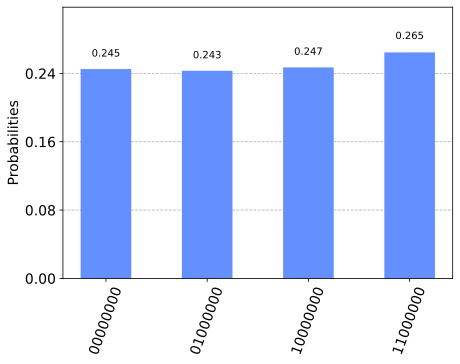

In [10]:
aer_backend = Aer.get_backend('qasm_simulator')
result = execute(qc, aer_backend).result()
counts = result.get_counts()
plot_histogram(counts)

From the discussion above we know that we will have a result for each value of $0 \le s \le r-1$ (in this case $r=4$ so $s\in[0,3]$ and we have 4 values). Remembering that the QPE algorithm returns $2^n \theta$, where $\theta$ is the phase to be computed, we obtained the following results from the algorithm:

In [11]:
rows, measured_phases = [],[]
for output in counts:
    decimal = int(output,2) #convert base 2 string to decimal
    phase = decimal/(2**n_count) #find the actual phase
    measured_phases.append(phase)
    rows.append([f"{output} (bin) = {decimal} (dec)", f"{decimal}/{2**n_count} = {phase:.2f}"])
headers=["Register output", "Phase"]
df=pd.DataFrame(rows, columns=headers)
print(df)

              Register output           Phase
0    00000000 (bin) = 0 (dec)    0/256 = 0.00
1   01000000 (bin) = 64 (dec)   64/256 = 0.25
2  10000000 (bin) = 128 (dec)  128/256 = 0.50
3  11000000 (bin) = 192 (dec)  192/256 = 0.75


To extract the value of $s$ and $r$ from these phases, we have to use the continued fractions algorithm seen above. Fortunately, python already has the built-in functionality in the `fractions` module. We can turn a float into a `Fraction` object, for example

In [12]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [13]:
5998794703657501/9007199254740992

0.666

But this can give gnarly results, we can limit the value of the denominator to get the fraction that resembles the value most closely

In [14]:
Fraction(0.666).limit_denominator(15) #limits DEN to 15

Fraction(2, 3)

We know that $r$ must be less than $N$, then we can use the above to get $r$!

In [15]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15) #we limit the DEN to N=15
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", f"{frac.denominator}"])
headers=["Phase","Fraction","Guess for r"]
df=pd.DataFrame(rows,columns=headers)
print(df)

   Phase Fraction Guess for r
0   0.00      0/1           1
1   0.25      1/4           4
2   0.50      1/2           2
3   0.75      3/4           4


Notice that in the first case $s=0$, which is to be avoided and always gives wrong results when using the CFA (continued fractions algorithm). The case $s=2$ also gives a wrong result: as discussed in the previous section, the CFA algorithm gives wrong results if $s$ and $r$ share a factor, which they do if $s=2, r=4$, hence we obtain $s'=1, r'=2$ which do not share a factor. The solution to this are explained at the end of previous section.

The cases $s=1,3$ give the correct result. Notice that here we just computed the very last convergent in the continued fraction expansion, i.e. the closest fraction that give the float result. The theorem in the previous section states that the fraction $s/r$ is *a* convergent of $\theta$, not necessarily the last (i.e. $s/r=\theta$, as in the case above). Here we had that $\theta=s/r$ exactly since we had more than enough bits to express it.

### Exercise
Check $a=2,8,11,13$.

**a=2**

In [18]:
a=2
n_count=8
qc=order_finding(2,8)
qc.draw('text')

┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐»
 q_8: ─────┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  2^1 mod 15 ││  2^2 mod 15 ││  2^4 mod 15 ││  2^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■─────────────────────────»
«             │               │               │                         »
« q_7: ───────┼───────────────┼───────────────┼────────────────■────────»
«      ┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴┼───────┐»
« q_8: ┤0             ├┤0             ├┤0             ├┤0      │       ├»
«      │              ││              ││              ││               │»
« q_9: ┤1             ├┤1             ├┤1             ├┤1              ├»
«      │  2^16 mod 15 ││  2^32 mod 15 ││  2^64 mod 15 ││  2^128 mod 15 │»
«q_10: ┤2             ├┤2             ├┤2             ├┤2              ├»
«      │              ││              ││              ││               │»
«q_11: ┤3             ├┤3             ├┤3             ├┤3              ├»
«      └──────────────┘└──────────────┘└──────────────┘└───────────────┘»
« c: 8/═════════════════════════════════════════════════════════════════»
«                                                                       »
«      ┌───────┐┌─┐                  

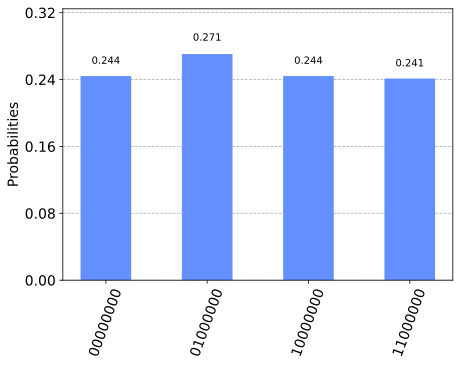

In [19]:
result = execute(qc, aer_backend).result()
counts = result.get_counts()
plot_histogram(counts)

In [20]:
rows, measured_phases = [],[]
for output in counts:
    decimal = int(output,2) #convert base 2 string to decimal
    phase = decimal/(2**n_count) #find the actual phase
    measured_phases.append(phase)
    rows.append([f"{output} (bin) = {decimal} (dec)", f"{decimal}/{2**n_count} = {phase:.2f}"])
headers=["Register output", "Phase"]
df=pd.DataFrame(rows, columns=headers)
print(df)

              Register output           Phase
0    00000000 (bin) = 0 (dec)    0/256 = 0.00
1   01000000 (bin) = 64 (dec)   64/256 = 0.25
2  10000000 (bin) = 128 (dec)  128/256 = 0.50
3  11000000 (bin) = 192 (dec)  192/256 = 0.75


In [21]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15) #we limit the DEN to N=15
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", f"{frac.denominator}"])
headers=["Phase","Fraction","Guess for r"]
df=pd.DataFrame(rows,columns=headers)
print(df)

   Phase Fraction Guess for r
0   0.00      0/1           1
1   0.25      1/4           4
2   0.50      1/2           2
3   0.75      3/4           4


we get exactly the same results! In this case $r=4$ since $2^4=1 \text{ (mod N)}$

**a=8**

In [22]:
a=8
n_count=8
qc = order_finding(8,8)
qc.draw('text')

┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐»
 q_8: ─────┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  8^1 mod 15 ││  8^2 mod 15 ││  8^4 mod 15 ││  8^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■─────────────────────────»
«             │               │               │                         »
« q_7: ───────┼───────────────┼───────────────┼────────────────■────────»
«      ┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴┼───────┐»
« q_8: ┤0             ├┤0             ├┤0             ├┤0      │       ├»
«      │              ││              ││              ││               │»
« q_9: ┤1             ├┤1             ├┤1             ├┤1              ├»
«      │  8^16 mod 15 ││  8^32 mod 15 ││  8^64 mod 15 ││  8^128 mod 15 │»
«q_10: ┤2             ├┤2             ├┤2             ├┤2              ├»
«      │              ││              ││              ││               │»
«q_11: ┤3             ├┤3             ├┤3             ├┤3              ├»
«      └──────────────┘└──────────────┘└──────────────┘└───────────────┘»
« c: 8/═════════════════════════════════════════════════════════════════»
«                                                                       »
«      ┌───────┐┌─┐                  

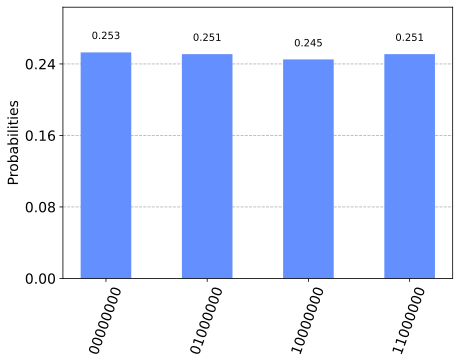

In [23]:
result = execute(qc, aer_backend).result()
counts = result.get_counts()
plot_histogram(counts)

In [24]:
rows, measured_phases = [],[]
for output in counts:
    decimal = int(output,2) #convert base 2 string to decimal
    phase = decimal/(2**n_count) #find the actual phase
    measured_phases.append(phase)
    rows.append([f"{output} (bin) = {decimal} (dec)", f"{decimal}/{2**n_count} = {phase:.2f}"])
headers=["Register output", "Phase"]
df=pd.DataFrame(rows, columns=headers)
print(df)

              Register output           Phase
0    00000000 (bin) = 0 (dec)    0/256 = 0.00
1   01000000 (bin) = 64 (dec)   64/256 = 0.25
2  10000000 (bin) = 128 (dec)  128/256 = 0.50
3  11000000 (bin) = 192 (dec)  192/256 = 0.75


In [25]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15) #we limit the DEN to N=15
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", f"{frac.denominator}"])
headers=["Phase","Fraction","Guess for r"]
df=pd.DataFrame(rows,columns=headers)
print(df)

   Phase Fraction Guess for r
0   0.00      0/1           1
1   0.25      1/4           4
2   0.50      1/2           2
3   0.75      3/4           4


same result as before $r=4, 8^4=4*4=1 \text{ (mod 15)}$. It is obvious that $a=2,4,8$ have the same order, since $8^r=2^{3r}=1$.

**a=11**

In [26]:
a=11
n_count=8
qc = order_finding(11,8)
qc.draw('text')

┌───┐                                                                »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────────»
      ├───┤       │                                                        »
 q_1: ┤ H ├───────┼───────────────■────────────────────────────────────────»
      ├───┤       │               │                                        »
 q_2: ┤ H ├───────┼───────────────┼───────────────■────────────────────────»
      ├───┤       │               │               │                        »
 q_3: ┤ H ├───────┼───────────────┼───────────────┼───────────────■────────»
      ├───┤       │               │               │               │        »
 q_4: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      ├───┤       │               │               │               │        »
 q_5: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      ├───┤       │               │               │               │        »
 q_6: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      ├───┤       │               │               │               │        »
 q_7: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      └───┘┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐»
 q_8: ─────┤0             ├┤0             ├┤0             ├┤0             ├»
           │              ││              ││              ││              │»
 q_9: ─────┤1             ├┤1             ├┤1             ├┤1             ├»
           │  11^1 mod 15 ││  11^2 mod 15 ││  11^4 mod 15 ││  11^8 mod 15 │»
q_10: ─────┤2             ├┤2             ├┤2             ├┤2             ├»
      ┌───┐│              ││              ││              ││              │»
q_11: ┤ X ├┤3             ├┤3             ├┤3             ├┤3             ├»
      └───┘└──────────────┘└──────────────┘└──────────────┘└──────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                           »
« q_0: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
« q_1: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
« q_2: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
« q_3: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
« q_4: ────────■────────────────────────────────────────────────────────────»
«              │                                                            »
« q_5: ────────┼────────────────■───────────────────────────────────────────»
«              │                │                                           »
« q_6: ────────┼────────────────┼────────────────■──────────────────────────»
«              │                │                │                          »
« q_7: ────────┼────────────────┼────────────────┼────────────────■─────────»
«      ┌──────┴┼───────┐┌──────┴┼───────┐┌──────┴┼───────┐┌───────┴────────┐»
« q_8: ┤0      │       ├┤0      │       ├┤0      │       ├┤0               ├»
«      │               ││               ││               ││                │»
« q_9: ┤1              ├┤1              ├┤1              ├┤1               ├»
«      │  11^16 mod 15 ││  11^32 mod 15 ││  11^64 mod 15 ││  11^128 mod 15 │»
«q_10: ┤2              ├┤2              ├┤2              ├┤2               ├»
«      │               ││               ││               ││                │»
«q_11: ┤3              ├┤3              ├┤3              ├┤3               ├»
«      └───────────────┘└───────────────┘└─────────────

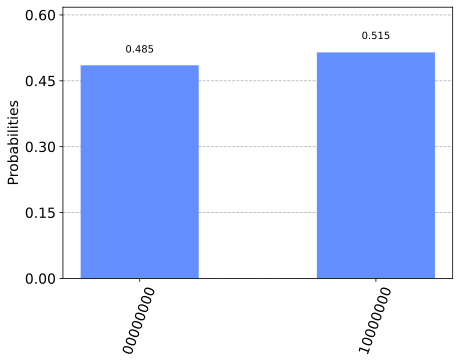

In [27]:
result = execute(qc, aer_backend).result()
counts = result.get_counts()
plot_histogram(counts)

In [28]:
rows, measured_phases = [],[]
for output in counts:
    decimal = int(output,2) #convert base 2 string to decimal
    phase = decimal/(2**n_count) #find the actual phase
    measured_phases.append(phase)
    rows.append([f"{output} (bin) = {decimal} (dec)", f"{decimal}/{2**n_count} = {phase:.2f}"])
headers=["Register output", "Phase"]
df=pd.DataFrame(rows, columns=headers)
print(df)

              Register output           Phase
0    00000000 (bin) = 0 (dec)    0/256 = 0.00
1  10000000 (bin) = 128 (dec)  128/256 = 0.50


In [29]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15) #we limit the DEN to N=15
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", f"{frac.denominator}"])
headers=["Phase","Fraction","Guess for r"]
df=pd.DataFrame(rows,columns=headers)
print(df)

   Phase Fraction Guess for r
0    0.0      0/1           1
1    0.5      1/2           2


So the only result we get, apart from $s=0$ is $s=1, r=2$. We can test that $11^2 = 1 \text{ (mod 15)}$, hence we got the exact result.

**a=13**

In [30]:
a = 13
n_count=8
qc = order_finding(a,n_count)
qc.draw('text')

┌───┐                                                                »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────────»
      ├───┤       │                                                        »
 q_1: ┤ H ├───────┼───────────────■────────────────────────────────────────»
      ├───┤       │               │                                        »
 q_2: ┤ H ├───────┼───────────────┼───────────────■────────────────────────»
      ├───┤       │               │               │                        »
 q_3: ┤ H ├───────┼───────────────┼───────────────┼───────────────■────────»
      ├───┤       │               │               │               │        »
 q_4: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      ├───┤       │               │               │               │        »
 q_5: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      ├───┤       │               │               │               │        »
 q_6: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      ├───┤       │               │               │               │        »
 q_7: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      └───┘┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐»
 q_8: ─────┤0             ├┤0             ├┤0             ├┤0             ├»
           │              ││              ││              ││              │»
 q_9: ─────┤1             ├┤1             ├┤1             ├┤1             ├»
           │  13^1 mod 15 ││  13^2 mod 15 ││  13^4 mod 15 ││  13^8 mod 15 │»
q_10: ─────┤2             ├┤2             ├┤2             ├┤2             ├»
      ┌───┐│              ││              ││              ││              │»
q_11: ┤ X ├┤3             ├┤3             ├┤3             ├┤3             ├»
      └───┘└──────────────┘└──────────────┘└──────────────┘└──────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                           »
« q_0: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
« q_1: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
« q_2: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
« q_3: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
« q_4: ────────■────────────────────────────────────────────────────────────»
«              │                                                            »
« q_5: ────────┼────────────────■───────────────────────────────────────────»
«              │                │                                           »
« q_6: ────────┼────────────────┼────────────────■──────────────────────────»
«              │                │                │                          »
« q_7: ────────┼────────────────┼────────────────┼────────────────■─────────»
«      ┌──────┴┼───────┐┌──────┴┼───────┐┌──────┴┼───────┐┌───────┴────────┐»
« q_8: ┤0      │       ├┤0      │       ├┤0      │       ├┤0               ├»
«      │               ││               ││               ││                │»
« q_9: ┤1              ├┤1              ├┤1              ├┤1               ├»
«      │  13^16 mod 15 ││  13^32 mod 15 ││  13^64 mod 15 ││  13^128 mod 15 │»
«q_10: ┤2              ├┤2              ├┤2              ├┤2               ├»
«      │               ││               ││               ││                │»
«q_11: ┤3              ├┤3              ├┤3              ├┤3               ├»
«      └───────────────┘└───────────────┘└─────────────

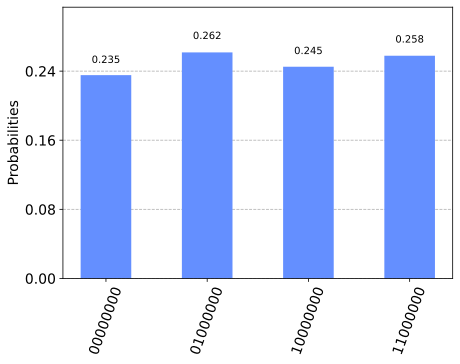

In [31]:
result = execute(qc, aer_backend).result()
counts = result.get_counts()
plot_histogram(counts)

In [32]:
rows, measured_phases = [],[]
for output in counts:
    decimal = int(output,2) #convert base 2 string to decimal
    phase = decimal/(2**n_count) #find the actual phase
    measured_phases.append(phase)
    rows.append([f"{output} (bin) = {decimal} (dec)", f"{decimal}/{2**n_count} = {phase:.2f}"])
headers=["Register output", "Phase"]
df=pd.DataFrame(rows, columns=headers)
print(df)

              Register output           Phase
0    00000000 (bin) = 0 (dec)    0/256 = 0.00
1   01000000 (bin) = 64 (dec)   64/256 = 0.25
2  10000000 (bin) = 128 (dec)  128/256 = 0.50
3  11000000 (bin) = 192 (dec)  192/256 = 0.75


In [33]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15) #we limit the DEN to N=15
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", f"{frac.denominator}"])
headers=["Phase","Fraction","Guess for r"]
df=pd.DataFrame(rows,columns=headers)
print(df)

   Phase Fraction Guess for r
0   0.00      0/1           1
1   0.25      1/4           4
2   0.50      1/2           2
3   0.75      3/4           4


We get the usual $r=4$ since $13^4 = 4 * 4 =1 \text{ (mod 15)}$, hence we got the same result as usual.

In [34]:
(13**4) % 15

1

## Modular Exponentiation

So, how did we obtain the circuit to apply the $C-U^{2^j}$ gates? The circuit we saw before is actually exponential in $L$, which defeats the purpose of having the circuit above run in $O(L^3)$ times. We want a way to do the following in an efficient way

$$
U^{2^j}|y\rangle = |a^{2^j} y \text{ mod N}\rangle
$$

Actually, we want to compute the sequence of controlled $U^{2^j}$, which returns

$$
|z\rangle |y\rangle \rightarrow |z\rangle U^{z_t 2^{t-1}} \dots U^{z_1 2^0}|y\rangle = |z\rangle |a^{z_t 2^{t-1}} \dots a^{z_1 2^0} y \text{ mod N}\rangle = |a^z y \text{ mod N}\rangle
$$

calculating $a^z \text{ mod N}$ can be achieved with complexity $O(L^3)$ by using the modular exponentiation algorithm. It consists in repeatedly squaring $a$ obtaining the following powers

$$
a \text{ mod N} \rightarrow a^2 \text{ mod N} \rightarrow \dots \rightarrow a^{2^{t-1}} \text{ mod N}
$$

Remembering that $t=O(L)$, the sqarings are $O(L^2)$ and are repeated $t=O(L)$ times, so this first part of the algorithm is $O(L^3)$. Now, to actually compute our result, we must compute $a^z \text{ mod N}$ using the powers we computed above. Remember that

$$
a^z \text{ mod N} = \Big( a^{z_t 2^{t-1}} \text{ mod N} \Big) \dots \Big( a^{z_1 2^0} \text{ mod N} \Big)
$$

we already have all of this powers, we just need to multiply together those for which $z_j=1$, for example

$$
x^{25} = x^{11001_2} = x^{16}* x^8 * x^1
$$

this product consists of $t-1=O(L)$ modular multiplication which cost $O(L^2)$, so again we have $O(L^3)$. This circuit can be constructed efficiently using the techniques of reversible computation and a third register.

Here on python we can use the above algorithm directly:

In [35]:
def a2jmodN(a,j,N):
    """Computes a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a=np.mod(a**2,N)
    return a

Here we compute any $a^{2^j} \text{ mod N}$ by repeatedly squaring it, which is all we need, and then we just need to control it on the first qubit. But we would like to implement this in a quantum algorithm, which creates a bottleneck in the algorithm (even though it's still $O(L^3)$) and are quite complex to produce, since require creating a classical reversible circuit and converting it into a quantum circuit.

# Factoring

We anticipated at the beginning that the factoring problem can be reduce to a order-finding problem. Not all numbers are difficult to factor, but a general rule to obtain difficult to factor numbers is to pick a number which is given from the product of 2 large primes, like in the RSA protocol.

We can show now that the factoring problem is reducible to the order-finding problem, meaning that an efficient solution to the order-finding problem can be converted to an efficient solution to factoring with at most a polynomial overhead. This can be demonstrated in two steps: first it can be shown that we can find a factor of $N$ if we can also find a non trivial solution to $x^2=1 \text{ (mod N)}$; then, we can show that a randomly chosen $y$ co-prime to $N$is liekly to have $r$ even and to be such that $y^{r/2}\ne\pm1 \text{ (mod N)}$, so that $x=y^{r/2} \text{ (mod N)}$ is a solution to $x^2=1 \text{ (mod N)}$. The two theorems are as follows

**Theorem 1**: consider $N$ to be an $L$ bits composite number, and $x$ a non trivial (i.e. $x\ne\pm 1 \text{ (mod N)}$, where $-1=N-1 \text{ (mod N)}$) solution to $x^2 = 1 \text{ (mod N)}$, with $1\le x \le N$. Then at least one between $gdc(x-1,N)$ and $gdc(x+1,N)$ is a non-trivial factor of $N$, and iut can be computed with Euclid's algorithm in $O(L^3)$.

**Theorem 2**: consider $N=p_1^{\alpha_1}\dots p_m^{\alpha_m}$ to be the factorization of an odd composite positive integer. Let x be an integer chosen uniformly at random in $[1,N-1]$ and co-prime to $N$. Let $r$ be the order of $x \text{ mod N}$, then we have that 

$$
P(r \text{ is even and } x^{r/2} \ne - 1 \text{ (mod N)}) \ge 1 - \frac{1}{2^m}
$$

In the theorem, we put only $-1$ since the fact $r/2$ is not an order already excludes the $1$ case.

Using this two theorems we can device an alorithm which with high probability returns a non-trivial factor of $N$, basically:

1. If $N$ is even, return $2$
2. If $N=a^b$ for $a\ge1, b\ge2$, then return $a$
3. If the above don't apply, choose uniformly $x \in [1,N-1]$. If $gcd(x,N)>1$ then return $gcd(x,N)$. Otherwise, $x$ is co-prime of $N$ and we must compute its order $r$. 
4. Use the order-finding subroutine to compute the order $r$ of $x \text{ mod N}$.
5. By Theorem 2, there's a high probability $r$ is even and $x^{r/2} \ne - 1 \text{ (mod N)}$. If this is the case, then $x^{r/2}$ is a non-trivial solution to $x^2=1 \text{ (mod N)}$ and thus, by Theorem 1, we compute $gcd(x^{r/2}+1, N)$ and $gcd(x^{r/2}-1, N)$ and check if any of these is a non-trivial factor of $N$. If not, the algorithm fails.

All the steps of the algorithm can be efficiently computed on a classical computer, except the order-finding subroutine, which is where our quantum algorithm comes to help. So step 1 and 2 return a factor in $O(1)$ and $O(L^3)$ respectively, or make sure $N$ is not odd or a power. Then step 3 either returns a factor in $O(L^3)$ or returns a random $x \in [1,\dots,N-1]$. Step 4 computes the order in $O(L^3)$ thanks to the quantum algorithm and step 5 completes the algorithm: Theorem 3 guarantees that $r$ is even and $x^{r/2} \ne - 1 \text{ (mod N)}$ with probability at least 1/2 (at this point, due to step 1 and 2, $N$ must be an odd integer with at least two different prime factors, hence $P \le 1-1/2 = 1/2$); then, Theorem 1 guarantees that either $gcd(x^{r/2}-1, N)$ or $gcd(x^{r/2}+1, N)$ is a factor of $N$.

 ## Example: factoring 15

We'll see how to factor $15$ as an example of the previous algorithm, and also because we already have a circuit for modular exponentiation with $N=15$

We already skipped the first 2 steps. We select $x$ randomly and use our order-finding algorithm to compute the order $r$.

In [36]:
N=15
np.random.seed(1) #we fix the seed to make sure our result can be reproduced
x = randint(2,15)
print(x)

7


We got $x=7$, as per the algorithm, we check it does not share a factor with $N$

In [37]:
from math import gcd
gcd(x,N)

1

We're good, now we can skip to the next step and compute the order of $x \text{ mod N}$ with $x=7, N=15$. Diffrently from before, we run our algorithm only once, as shown in the function below.

In [38]:
def order_finding_shor(a, n_count):
    qc = order_finding(a,n_count)
    backend= Aer.get_backend('qasm_simulator')
    #We simulate the algorithm only once
    #Setting memory=True allows us to see a list of each sequential reading
    result = execute(qc, backend, shots=1, memory=True).result()
    #we get all reading in a list
    readings = result.get_memory()
    print("Register Reading: " + readings[0])#last reading
    phase = int(readings[0],2)/(2**n_count) #get last phase read
    print(f"Corresponding Phase: {phase:f}")
    return phase

We run our alogrithm only once! From the phase obtained we can easily guess the value of $r$:

In [39]:
np.random.seed(3)
phase = order_finding_shor(a,3) #returns phase=s/r
frac = Fraction(phase).limit_denominator(N) #we hope DEN is r!
s, r = frac.numerator, frac.denominator
print(r)

Register Reading: 010
Corresponding Phase: 0.250000
4


Now that we have $r$, we might be able to use it to find a factor of $N$. Let's retrace the reasoning above instead of just applying the algorithm. Since:

$$
a^r = 1 \text{ (mod N)}
$$

then $a^r-1=0 \text{ (mod N)}$, which means that $N$ must divide $a^r-1$. If $r$ is even:

$$
a^r-1=(a^{r/2}-1)(a^{r/2}+1)
$$

(if $r$ is odd, we must repeat the steps above). There is now a high probability that $x^{r/2}\ne -1 \text{mod N)}$, which means that the above holds and thus $N$ must have a common factor with one of the two factors above, which must be less than $N$. Hence:

In [42]:
guesses = [gcd(a**(r//2)-1,N), gcd(a**(r//2)+1,N)]
print(guesses)

[3, 5]


Notice that we may find the right factors in one, two or more steps. We rerun the algorithm below so that we can see how it behaves:

In [66]:
a = 7
factor_found=False
attempt=0
while not factor_found:
    attempt+=1
    print(f"Attempt: {attempt}")
    phase = order_finding_shor(a,3) #phase=s/r
    frac = Fraction(phase).limit_denominator(N)
    r=frac.denominator
    print(f"Result: r={r}")
    if phase!=0:
        #guess factors
        guesses = [gcd(a**(r//2)-1,N), gcd(a**(r//2)+1,N)]
        print(f"Guessed Factors: {guesses}")
        if a**(r//2)%N==-1 or a**(r//2)%N==1:
            print("We have: a^(r/2) = +-1 (mod N)")
        for guess in guesses:
            if guess!=1 and N%guess==0: #check to see if it's a factor
                print(f"*** Non-trivial factor found: {guess} ***")
                factor_found=True

Attempt: 1
Register Reading: 000
Corresponding Phase: 0.000000
Result: r=1
Attempt: 2
Register Reading: 010
Corresponding Phase: 0.250000
Result: r=4
Guessed Factors: [3, 5]
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


We see that most times we get the correct solution $[3,5]$, with $s=1,3$. Sometimes we get the result $[3,1]$ when $r=2$ in the case of $s=2$, but this is still gives a correct answer because $gcd(6,15)=3$, and we get not correct solution when $s=0$ since $r=1$ in this case and it's not even.

Check Nielsen-Chuang to see a more indept description of the factorization of 15.